In [1]:
import sklearn
print(sklearn.__version__)

1.3.2


In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, classification_report
pd.set_option('display.max_columns',None)
import joblib

#### 

#### Importando a base de dados feita com o script de coleta de dados a partir do Yahoofinance, atualmente para não pesar temos apenas 3 ativos. Mas podemos fazer todos ativos da bolsa disponível quando desejar.

In [2]:
price_data = pd.read_parquet(f'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Dados_bolsa_interpolar.parquet')
price_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.291125,985,ABEV3.SA
1,2000-01-06,0.494478,0.494478,0.494478,0.494478,0.276367,227,ABEV3.SA
2,2000-01-12,0.481293,0.481293,0.481293,0.481293,0.268998,1137,ABEV3.SA
3,2000-01-13,0.484589,0.484589,0.484589,0.484589,0.270840,606,ABEV3.SA
4,2000-01-14,0.494478,0.494478,0.494478,0.494478,0.276367,6445,ABEV3.SA


In [3]:
price_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27044 entries, 0 to 27043
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       27044 non-null  datetime64[ns]
 1   Open       27044 non-null  float64       
 2   High       27044 non-null  float64       
 3   Low        27044 non-null  float64       
 4   Close      27044 non-null  float64       
 5   Adj Close  27044 non-null  float64       
 6   Volume     27044 non-null  int64         
 7   Ticker     27044 non-null  object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 1.7+ MB


#### Ordenando por data e ticker e pegando a diferença do dia anterior.

In [4]:
price_data['Date'] = pd.to_datetime(price_data['Date'])
price_data.sort_values(by = ['Ticker','Date'], inplace = True)

price_data['change_in_price'] = price_data['Close'].diff()
price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price
11779,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000
11780,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001
11781,2025-01-23,52.950001,52.990002,51.840000,52.320000,52.320000,25097300,VALE3.SA,-0.340000
11782,2025-01-24,52.599998,53.189999,52.599998,53.029999,53.029999,20520600,VALE3.SA,0.709999
11783,2025-01-27,52.889999,53.009998,52.570000,52.910000,52.910000,1252600,VALE3.SA,-0.119999


In [5]:
# Função para suavização exponencial
def exponential_smoothing(data, alpha):
    """
    Aplica a suavização exponencial nos dados.
    :param data: Série de dados (array-like ou pandas Series).
    :param alpha: Fator de suavização (0 < alpha < 1).
    :return: Série suavizada.
    """
    smoothed = np.zeros(len(data))
    smoothed[0] = data[0]  # Inicializa com o primeiro valor
    for t in range(1, len(data)):
        smoothed[t] = alpha * data[t] + (1 - alpha) * smoothed[t-1]
    return smoothed

# Função para calcular o target
def calculate_target(data, d):
    """
    Calcula o target usando a fórmula do sinal da diferença de preços.
    :param data: Série de preços de fechamento (array-like ou pandas Series).
    :param d: Período para calcular a diferença futura.
    :return: Série com os valores do target (-1, 0, 1).
    """
    return np.sign(data.shift(-d) - data)



# Aplicando a suavização exponencial
alpha = 0.20
price_data['Smoothed_Close'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha)
)

# Calculando o target para d = 10 dias
d = 10
price_data['Prediction'] = price_data.groupby('Ticker')['Smoothed_Close'].transform(
    lambda x: calculate_target(x, d)
)

price_data.head()


,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.291125,985,ABEV3.SA,NaN,0.520882,-1.0
1,2000-01-06,0.494478,0.494478,0.494478,0.494478,0.276367,227,ABEV3.SA,-0.026404,0.515601,-1.0
2,2000-01-12,0.481293,0.481293,0.481293,0.481293,0.268998,1137,ABEV3.SA,-0.013185,0.508740,-1.0
3,2000-01-13,0.484589,0.484589,0.484589,0.484589,0.270840,606,ABEV3.SA,0.003296,0.503909,-1.0
4,2000-01-14,0.494478,0.494478,0.494478,0.494478,0.276367,6445,ABEV3.SA,0.009889,0.502023,-1.0


In [6]:
# Função para suavização exponencial
def exponential_smoothing(data, alpha):
    """
    Aplica a suavização exponencial nos dados.
    :param data: Série de dados (array-like ou pandas Series).
    :param alpha: Fator de suavização (0 < alpha < 1).
    :return: Série suavizada.
    """
    smoothed = np.zeros(len(data))
    smoothed[0] = data[0]  # Inicializa com o primeiro valor
    for t in range(1, len(data)):
        smoothed[t] = alpha * data[t] + (1 - alpha) * smoothed[t-1]
    return smoothed

# Função para calcular o target
def calculate_target(data, d):
    """
    Calcula o target usando a fórmula do sinal da diferença de preços.
    :param data: Série de preços de fechamento (array-like ou pandas Series).
    :param d: Período para calcular a diferença futura.
    :return: Série com os valores do target (-1, 0, 1).
    """
    target = np.sign(data.shift(-d) - data)
    target[target == 0] = -1  # Substitui os 0 por -1
    return target



# Aplicando a suavização exponencial
alpha = 1
price_data['Smoothed_Close_1'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha)
)

# Calculando o target para d = 10 dias
d = 10
price_data['Verify'] = price_data.groupby('Ticker')['Smoothed_Close_1'].transform(
    lambda x: calculate_target(x, d)
)

price_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.291125,985,ABEV3.SA,NaN,0.520882,-1.0,0.520882,-1.0
1,2000-01-06,0.494478,0.494478,0.494478,0.494478,0.276367,227,ABEV3.SA,-0.026404,0.515601,-1.0,0.494478,1.0
2,2000-01-12,0.481293,0.481293,0.481293,0.481293,0.268998,1137,ABEV3.SA,-0.013185,0.508740,-1.0,0.481293,1.0
3,2000-01-13,0.484589,0.484589,0.484589,0.484589,0.270840,606,ABEV3.SA,0.003296,0.503909,-1.0,0.484589,1.0
4,2000-01-14,0.494478,0.494478,0.494478,0.494478,0.276367,6445,ABEV3.SA,0.009889,0.502023,-1.0,0.494478,-1.0


In [7]:
# Aplicando o deslocamento de 10 linhas dentro de cada grupo de 'Ticker'
price_data['Close_10'] = price_data.groupby('Ticker')['Close'].shift(-10)
price_data['Smoothed_Close_10'] = price_data.groupby('Ticker')['Smoothed_Close'].shift(-10)

#### Tirando a diferença do 'Smoothed_Close' na virada de um tick para outro.

In [8]:
mask = price_data['Ticker'] != price_data['Ticker'].shift(1)

price_data['change_in_price'] = np.where(mask == True, np.nan, price_data['change_in_price'])

price_data[price_data.isna().any(axis = 1)]

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.291125,985,ABEV3.SA,NaN,0.520882,-1.0,0.520882,-1.0,0.520882,0.499416
5741,2025-01-14,11.210000,11.370000,11.150000,11.210000,11.210000,42625300,ABEV3.SA,-0.030000,11.447544,NaN,11.210000,NaN,NaN,NaN
5742,2025-01-15,11.300000,11.430000,11.160000,11.390000,11.390000,45380700,ABEV3.SA,0.180000,11.436035,NaN,11.390000,NaN,NaN,NaN
5743,2025-01-16,11.420000,11.420000,11.040000,11.080000,11.080000,29298500,ABEV3.SA,-0.310000,11.364828,NaN,11.080000,NaN,NaN,NaN
5744,2025-01-17,10.840000,11.090000,10.770000,11.090000,11.090000,51433600,ABEV3.SA,0.010000,11.309862,NaN,11.090000,NaN,NaN,NaN
5745,2025-01-20,11.050000,11.110000,10.790000,11.050000,11.050000,22293700,ABEV3.SA,-0.040000,11.257890,NaN,11.050000,NaN,NaN,NaN
5746,2025-01-21,10.990000,11.260000,10.990000,11.250000,11.250000,26293900,ABEV3.SA,0.200000,11.256312,NaN,11.250000,NaN,NaN,NaN
5747,2025-01-22,11.180000,11.220000,10.940000,11.020000,11.020000,44993500,ABEV3.SA,-0.230000,11.209050,NaN,11.020000,NaN,NaN,NaN
5748,2025-01-23,11.020000,11.160000,10.980000,11.050000,11.050000,35708100,ABEV3.SA,0.030000,11.177240,NaN,11.050000,NaN,NaN,NaN
5749,2025-01-24,11.050000,11.130000,10.870000,10.870000,10.870000,44514500,ABEV3.SA,-0.180000,11.115792,NaN,10.870000,NaN,NaN,NaN


#### Calculando o RSI.

**Fórmula:**

\begin{align}
\ RSI = 100 - \frac{100}{1+RS}
\end{align}

In [9]:
# Período do indicador.
n = 14

# Dias de alta e dias de baixa
up_df, down_df = price_data[['Ticker','change_in_price']].copy(), price_data[['Ticker','change_in_price']].copy()

# Salvando a diferença para dias de alta.
up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0

# Salvando a diferença para dias de baixa
down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0

# Colocando as diferenças do dia de baixa em termos absolutos
down_df['change_in_price'] = down_df['change_in_price'].abs()


ewma_up = up_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

relative_strength = ewma_up / ewma_down

# Calculando o indicador
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

price_data['down_days'] = down_df['change_in_price']
price_data['up_days'] = up_df['change_in_price']
price_data['RSI'] = relative_strength_index

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI
11779,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,53.305458,NaN,54.020000,NaN,NaN,NaN,0.270000,0.000000,59.669614
11780,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,53.176367,NaN,52.660000,NaN,NaN,NaN,1.360001,0.000000,42.517082
11781,2025-01-23,52.950001,52.990002,51.840000,52.320000,52.320000,25097300,VALE3.SA,-0.340000,53.005093,NaN,52.320000,NaN,NaN,NaN,0.340000,0.000000,39.261492
11782,2025-01-24,52.599998,53.189999,52.599998,53.029999,53.029999,20520600,VALE3.SA,0.709999,53.010074,NaN,53.029999,NaN,NaN,NaN,0.000000,0.709999,48.722174
11783,2025-01-27,52.889999,53.009998,52.570000,52.910000,52.910000,1252600,VALE3.SA,-0.119999,52.990059,NaN,52.910000,NaN,NaN,NaN,0.119999,0.000000,47.285835


## Calculando o Stochastic Oscillator

**Fórmula:**

\begin{align}
\ K = 100 \ast  \frac{(C-L_{14})}{(H_{14}-L_{14})}
\end{align}

$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ C = \text{Current Closing Price}
\end{align}
$

$
\begin{align}
\ L_{14} = \text{Lowest Low over the past 14 days}
\end{align}
$

$
\begin{align}
\ H_{14} = \text{Highest High over the past 14 days}
\end{align}
$


In [10]:
t = 14
low_t, high_t = price_data[['Ticker','Low']].copy(), price_data[['Ticker','High']].copy()
low_t = low_t.groupby('Ticker')['Low'].transform(lambda x: x.rolling(window = t).min())
high_t = high_t.groupby('Ticker')['High'].transform(lambda x: x.rolling(window = t).max())

k_percent = 100 * ((price_data['Smoothed_Close'] - low_t) / (high_t - low_t))

price_data[f'low_{t}'] = low_t
price_data[f'high_{t}'] = high_t
price_data[f'k_percent_{t}'] = k_percent

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_14,high_14,k_percent_14
11779,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,53.305458,NaN,54.020000,NaN,NaN,NaN,0.270000,0.000000,59.669614,50.869999,55.099998,57.575879
11780,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,53.176367,NaN,52.660000,NaN,NaN,NaN,1.360001,0.000000,42.517082,50.869999,54.490002,63.711767
11781,2025-01-23,52.950001,52.990002,51.840000,52.320000,52.320000,25097300,VALE3.SA,-0.340000,53.005093,NaN,52.320000,NaN,NaN,NaN,0.340000,0.000000,39.261492,50.869999,54.490002,58.980461
11782,2025-01-24,52.599998,53.189999,52.599998,53.029999,53.029999,20520600,VALE3.SA,0.709999,53.010074,NaN,53.029999,NaN,NaN,NaN,0.000000,0.709999,48.722174,50.869999,54.490002,59.118061
11783,2025-01-27,52.889999,53.009998,52.570000,52.910000,52.910000,1252600,VALE3.SA,-0.119999,52.990059,NaN,52.910000,NaN,NaN,NaN,0.119999,0.000000,47.285835,50.869999,54.490002,58.565163


## Calculando o indicador Williams %R

**Fórmula:**

\begin{align}
\ R = \frac{(H_{14}-C)}{(H_{14}-L_{14})} * - 100
\end{align}

$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ C = \text{Current Closing Price}
\end{align}
$

$
\begin{align}
\ L_{14} = \text{Lowest Low over the past 14 days}
\end{align}
$

$
\begin{align}
\ H_{14} = \text{Highest High over the past 14 days}
\end{align}
$


In [11]:
# Período de cálculo do indicador
t = 14

low_t, high_t = price_data[['Ticker','Low']].copy(), price_data[['Ticker','High']].copy()

#Aplicanod a função no grupo
low_t = low_t.groupby('Ticker')['Low'].transform(lambda x: x.rolling(window = t).min())
high_t = high_t.groupby('Ticker')['High'].transform(lambda x: x.rolling(window = t).max())

# Calculando o indicador
r_percent = ((high_t - price_data['Smoothed_Close']) / (high_t - low_t)) * (- 100)

price_data[f'r_percent_{t}'] = r_percent

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14
11779,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,53.305458,NaN,54.020000,NaN,NaN,NaN,0.270000,0.000000,59.669614,50.869999,55.099998,57.575879,-42.424121
11780,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,53.176367,NaN,52.660000,NaN,NaN,NaN,1.360001,0.000000,42.517082,50.869999,54.490002,63.711767,-36.288233
11781,2025-01-23,52.950001,52.990002,51.840000,52.320000,52.320000,25097300,VALE3.SA,-0.340000,53.005093,NaN,52.320000,NaN,NaN,NaN,0.340000,0.000000,39.261492,50.869999,54.490002,58.980461,-41.019539
11782,2025-01-24,52.599998,53.189999,52.599998,53.029999,53.029999,20520600,VALE3.SA,0.709999,53.010074,NaN,53.029999,NaN,NaN,NaN,0.000000,0.709999,48.722174,50.869999,54.490002,59.118061,-40.881939
11783,2025-01-27,52.889999,53.009998,52.570000,52.910000,52.910000,1252600,VALE3.SA,-0.119999,52.990059,NaN,52.910000,NaN,NaN,NaN,0.119999,0.000000,47.285835,50.869999,54.490002,58.565163,-41.434837


## Cálculo do indicador Moving Average Convergence Divergnece (MACD)

**Fórmula:**


\begin{align}
\ MACD = EMA_{12}(C) - EMA_{26}(C)
\end{align}

\begin{align}
\ SignalLine = EMA_{9}(MACD)
\end{align}


$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ MACD = \text{Moving Average Convergence Divergence}
\end{align}
$

$
\begin{align}
\ C = \text{Closing Price}
\end{align}
$

$
\begin{align}
\ EMA_{n} = \text{n day Exponential Moving Average}
\end{align}
\\
$


In [12]:
# Calculando o MACD
ema_26 = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

# Calculando a EMA
ema_9_macd = macd.ewm(span = 9).mean()


price_data['MACD'] = macd
price_data['MACD_EMA'] = ema_9_macd


price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA
11779,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,53.305458,NaN,54.020000,NaN,NaN,NaN,0.270000,0.000000,59.669614,50.869999,55.099998,57.575879,-42.424121,-1.254436,-1.368394
11780,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,53.176367,NaN,52.660000,NaN,NaN,NaN,1.360001,0.000000,42.517082,50.869999,54.490002,63.711767,-36.288233,-1.171086,-1.328933
11781,2025-01-23,52.950001,52.990002,51.840000,52.320000,52.320000,25097300,VALE3.SA,-0.340000,53.005093,NaN,52.320000,NaN,NaN,NaN,0.340000,0.000000,39.261492,50.869999,54.490002,58.980461,-41.019539,-1.106101,-1.284366
11782,2025-01-24,52.599998,53.189999,52.599998,53.029999,53.029999,20520600,VALE3.SA,0.709999,53.010074,NaN,53.029999,NaN,NaN,NaN,0.000000,0.709999,48.722174,50.869999,54.490002,59.118061,-40.881939,-1.042184,-1.235930
11783,2025-01-27,52.889999,53.009998,52.570000,52.910000,52.910000,1252600,VALE3.SA,-0.119999,52.990059,NaN,52.910000,NaN,NaN,NaN,0.119999,0.000000,47.285835,50.869999,54.490002,58.565163,-41.434837,-0.981827,-1.185109


### Cálculo do indicador Price Rate Of Change

**Formula:**


\begin{align}
\\
\ PROC_{t} = \frac{C_{t} - C_{t-n}}{C_{t-n}}
\\
\end{align}


$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ PROC_{t} = \text{Price Rate of Change at time t}
\end{align}
$

$
\begin{align}
\ C_{t} = \text{Closing price at time t}
\end{align}
\\
$


In [13]:
# Período do indicador
e = 14

# Calculando o Price Rate
price_data['Price_Rate_Of_Change'] = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.pct_change(periods = e))

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,Price_Rate_Of_Change
11779,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,53.305458,NaN,54.020000,NaN,NaN,NaN,0.270000,0.000000,59.669614,50.869999,55.099998,57.575879,-42.424121,-1.254436,-1.368394,-0.033897
11780,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,53.176367,NaN,52.660000,NaN,NaN,NaN,1.360001,0.000000,42.517082,50.869999,54.490002,63.711767,-36.288233,-1.171086,-1.328933,-0.032992
11781,2025-01-23,52.950001,52.990002,51.840000,52.320000,52.320000,25097300,VALE3.SA,-0.340000,53.005093,NaN,52.320000,NaN,NaN,NaN,0.340000,0.000000,39.261492,50.869999,54.490002,58.980461,-41.019539,-1.106101,-1.284366,-0.029930
11782,2025-01-24,52.599998,53.189999,52.599998,53.029999,53.029999,20520600,VALE3.SA,0.709999,53.010074,NaN,53.029999,NaN,NaN,NaN,0.000000,0.709999,48.722174,50.869999,54.490002,59.118061,-40.881939,-1.042184,-1.235930,-0.022394
11783,2025-01-27,52.889999,53.009998,52.570000,52.910000,52.910000,1252600,VALE3.SA,-0.119999,52.990059,NaN,52.910000,NaN,NaN,NaN,0.119999,0.000000,47.285835,50.869999,54.490002,58.565163,-41.434837,-0.981827,-1.185109,-0.014863


## Cálculo do indicador On Balance Volume

#### Formula:

$
\begin{equation}
OBV (t) =
    \begin{cases}
      \text{OBV(t - 1) + Vol(t) if C(t) > C(t-1)}\\
      \text{OBV(t - 1) - Vol(t) if C(t) < C(t-1)}\\
      \text{OBV(t - 1) if C(t) = C(t-1)}\\
    \end{cases}\\
\\
\text{where,}\\
\\
\text{OBV (t) = on balance volume at time t}\\
\\
\text{Vol(t) = trading volume at time t}\\
\\
\text{C(t) = closing price at time t}\\
\end{equation}
$


In [14]:
def obv(group):

    Volume = group['Volume']
    change = group['Smoothed_Close'].diff()

    prev_obv = 0
    obv_values = []

    # Calculando o indicador
    for i, j in zip(change, Volume):

        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv

        
        prev_obv = current_obv
        obv_values.append(current_obv)
    
    # Retornando em pandas series
    return pd.Series(obv_values, index = group.index)
        

# aplicando a função em cada grupo
obv_groups = price_data.groupby('Ticker').apply(obv)

price_data['On Balance Volume'] = obv_groups.reset_index(level=0, drop=True)

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
11779,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,53.305458,NaN,54.020000,NaN,NaN,NaN,0.270000,0.000000,59.669614,50.869999,55.099998,57.575879,-42.424121,-1.254436,-1.368394,-0.033897,2329297670
11780,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,53.176367,NaN,52.660000,NaN,NaN,NaN,1.360001,0.000000,42.517082,50.869999,54.490002,63.711767,-36.288233,-1.171086,-1.328933,-0.032992,2294652270
11781,2025-01-23,52.950001,52.990002,51.840000,52.320000,52.320000,25097300,VALE3.SA,-0.340000,53.005093,NaN,52.320000,NaN,NaN,NaN,0.340000,0.000000,39.261492,50.869999,54.490002,58.980461,-41.019539,-1.106101,-1.284366,-0.029930,2269554970
11782,2025-01-24,52.599998,53.189999,52.599998,53.029999,53.029999,20520600,VALE3.SA,0.709999,53.010074,NaN,53.029999,NaN,NaN,NaN,0.000000,0.709999,48.722174,50.869999,54.490002,59.118061,-40.881939,-1.042184,-1.235930,-0.022394,2290075570
11783,2025-01-27,52.889999,53.009998,52.570000,52.910000,52.910000,1252600,VALE3.SA,-0.119999,52.990059,NaN,52.910000,NaN,NaN,NaN,0.119999,0.000000,47.285835,50.869999,54.490002,58.565163,-41.434837,-0.981827,-1.185109,-0.014863,2288822970


## Removendo Nans

In [15]:
# We need to remove all rows that have an NaN value.
print('Antes de tirar as NaN nós tinhamos {} linhas e {} colunas'.format(price_data.shape[0], price_data.shape[1]))

# Any row that has a `NaN` value will be dropped.
price_data = price_data.dropna()

# Display how much we have left now.
print('Depois da retirada dos NaN temos {} linhas e {} colunas'.format(price_data.shape[0], price_data.shape[1]))

# Print the head.
price_data.head()

Antes de tirar as NaN nós tinhamos 27044 linhas e 26 colunas
Depois da retirada dos NaN temos 26924 linhas e 26 colunas


,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
14,2000-02-23,0.494478,0.494478,0.494478,0.494478,0.276367,455,ABEV3.SA,0.009223,0.498239,1.0,0.494478,1.0,0.556475,0.519913,0.000000,0.009223,47.299662,0.468107,0.527474,50.755749,-49.244251,-0.001487,-0.001225,-0.043470,27075
15,2000-02-24,0.487885,0.487885,0.487885,0.487885,0.272682,5005,ABEV3.SA,-0.006593,0.496168,1.0,0.487885,1.0,0.567030,0.529336,0.006593,0.000000,44.667003,0.468107,0.527474,47.267558,-52.732442,-0.001661,-0.001314,-0.037690,22070
16,2000-02-25,0.474700,0.474700,0.474700,0.474700,0.265313,3033,ABEV3.SA,-0.013185,0.491875,1.0,0.474700,1.0,0.567030,0.536875,0.013185,0.000000,39.583155,0.468107,0.527474,40.035143,-59.964857,-0.002040,-0.001463,-0.033150,19037
17,2000-02-29,0.468107,0.468107,0.468107,0.468107,0.261628,11602,ABEV3.SA,-0.006593,0.487121,1.0,0.468107,1.0,0.593400,0.548180,0.006593,0.000000,37.143972,0.468107,0.527474,32.028114,-67.971886,-0.002604,-0.001695,-0.033316,7435
18,2000-03-03,0.512957,0.512957,0.512957,0.512957,0.286695,758,ABEV3.SA,0.044850,0.492288,1.0,0.512957,1.0,0.606585,0.559861,0.000000,0.044850,57.635161,0.468107,0.527474,40.731890,-59.268110,-0.002674,-0.001894,-0.019391,8193


## VALIDAÇÃO

#### Testando paramêtros

In [30]:
price_data_ABEV = price_data[price_data['Ticker'].isin(['ABEV3.SA'])]

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import winsound

# Supondo que você já tem o price_data_ABEV carregado
X_Cols = price_data_ABEV[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar lista para armazenar resultados
results = []

# Laço para variar n_estimators de 10 a 2000, em passos de 10
for n in range(10, 501, 10):
    # Criar o modelo de Random Forest com o número atual de estimadores
    rand_frst_clf = RandomForestClassifier(n_estimators=n, oob_score=True, criterion="gini", random_state=0)
    
    # Ajustar o modelo aos dados de treino
    rand_frst_clf.fit(X_train, y_train)
    
    # Fazer previsões nos dados de teste
    y_pred = rand_frst_clf.predict(X_test)
    
    # Calcular acurácia
    accuracy = accuracy_score(y_test, y_pred) * 100.0
    
    # Armazenar o resultado
    results.append((n, accuracy))
    
    # Imprimir progresso
    print(f'n_estimators: {n}, Accuracy: {accuracy:.2f}%')

winsound.Beep(440, 300)


c:\ProgramData\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


n_estimators: 10, Accuracy: 76.68%
n_estimators: 20, Accuracy: 78.56%
n_estimators: 30, Accuracy: 78.00%
n_estimators: 40, Accuracy: 77.93%
n_estimators: 50, Accuracy: 78.42%
n_estimators: 60, Accuracy: 78.98%


KeyboardInterrupt: 


Testando para n_estimators=10
  Accuracy with Y_test (Prediction): 0.4937
  Accuracy with Verify: 0.4958
  Accuracy with Y_test (Prediction): 0.5440
  Accuracy with Verify: 0.5199
  Accuracy with Y_test (Prediction): 0.5608
  Accuracy with Verify: 0.4895
  Accuracy with Y_test (Prediction): 0.5786
  Accuracy with Verify: 0.5367
  Accuracy with Y_test (Prediction): 0.5660
  Accuracy with Verify: 0.4780
  Média de acurácia com Prediction: 0.5486
  Média de acurácia com Verify: 0.5040

Testando para n_estimators=20
  Accuracy with Y_test (Prediction): 0.5199
  Accuracy with Verify: 0.5115
  Accuracy with Y_test (Prediction): 0.5608
  Accuracy with Verify: 0.5325
  Accuracy with Y_test (Prediction): 0.5629
  Accuracy with Verify: 0.4581
  Accuracy with Y_test (Prediction): 0.5734
  Accuracy with Verify: 0.5377
  Accuracy with Y_test (Prediction): 0.5650
  Accuracy with Verify: 0.4811
  Média de acurácia com Prediction: 0.5564
  Média de acurácia com Verify: 0.5042

Testando para n_estimat

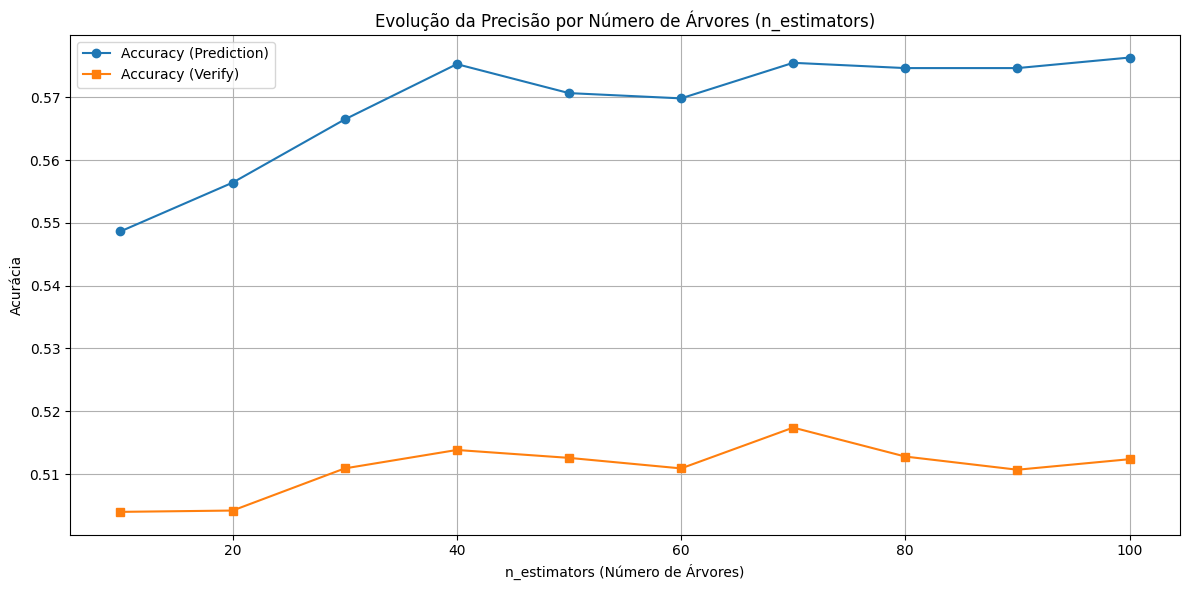

In [32]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import warnings
import winsound

# Desativa warnings
warnings.filterwarnings("ignore")

# Preparando as colunas de treino
X_Cols = price_data_ABEV[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']

# Variável adicional de verificação
verify = price_data_ABEV['Verify']

# Intervalo de valores para o hiperparâmetro (n_estimators neste caso)
param_range = range(10, 101, 10)

# Dicionários para armazenar os resultados
results = {"n_estimators": [], "mean_accuracy_prediction": [], "mean_accuracy_verify": []}

# Loop para testar diferentes valores de n_estimators
for n_estimators in param_range:
    print(f"\nTestando para n_estimators={n_estimators}")

    # Criando o modelo Random Forest com o hiperparâmetro atual
    rand_frst_clf_Ambev = RandomForestClassifier(n_estimators=n_estimators, oob_score=True, criterion="gini", random_state=0)

    # Inicializando variáveis para armazenar resultados
    accuracy_scores_ytest = []
    accuracy_scores_verify = []

    # Time Series Split
    tscv = TimeSeriesSplit(n_splits=5)
    fold = 1

    # Loop de cross-validation
    for train_index, test_index in tscv.split(X_Cols):
        # Dividindo os dados em treino e teste para a divisão atual
        X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
        y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
        y_verify = verify.iloc[test_index]

        # Treinando o modelo
        rand_frst_clf_Ambev.fit(X_train, y_train)

        # Fazendo predições
        y_pred = rand_frst_clf_Ambev.predict(X_test)

        # Calculando acurácias
        accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
        accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
        accuracy_scores_ytest.append(accuracy_ytest)
        accuracy_scores_verify.append(accuracy_verify)
        
        # Exibindo acurácias para o fold atual
        print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
        print(f"  Accuracy with Verify: {accuracy_verify:.4f}")


        fold += 1

    # Calculando as médias de acurácia para o hiperparâmetro atual
    mean_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
    mean_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

    # Armazenando os resultados no dicionário
    results["n_estimators"].append(n_estimators)
    results["mean_accuracy_prediction"].append(mean_accuracy_ytest)
    results["mean_accuracy_verify"].append(mean_accuracy_verify)

    # Exibindo os resultados do hiperparâmetro atual
    print(f"  Média de acurácia com Prediction: {mean_accuracy_ytest:.4f}")
    print(f"  Média de acurácia com Verify: {mean_accuracy_verify:.4f}")



# Convertendo os resultados para DataFrame
results_df = pd.DataFrame(results)

# Gerando gráficos para visualizar as métricas
plt.figure(figsize=(12, 6))

# Gráfico das médias de acurácias
plt.plot(results_df["n_estimators"], results_df["mean_accuracy_prediction"], label="Accuracy (Prediction)", marker="o")
plt.plot(results_df["n_estimators"], results_df["mean_accuracy_verify"], label="Accuracy (Verify)", marker="s")

# Configuração do gráfico
plt.title("Evolução da Precisão por Número de Árvores (n_estimators)")
plt.xlabel("n_estimators (Número de Árvores)")
plt.ylabel("Acurácia")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

results_df.head()
winsound.Beep(440, 300)


#### Max_depth_values - Prediction

In [94]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import warnings

# Desativa warnings
warnings.filterwarnings("ignore")


# Preparando as colunas de treino
X_Cols = price_data_ABEV[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']

# Variável adicional de verificação
verify = price_data_ABEV['Verify']

# Time Series Split: Número de divisões
tscv = TimeSeriesSplit(n_splits=5)

# Inicializando variáveis para armazenar resultados
report_dict = {}
accuracy_scores_ytest = []
accuracy_scores_verify = []
predictions = []
verify_values = []
actual_y_test_values = []

# Laço para ajustar o max_depth de 1 a 40
for max_depth in range(1, 41):  # max_depth variando de 1 a 40
    print(f"\nAjustando o max_depth = {max_depth}:")
    
    # Criando o modelo Random Forest com o max_depth atual
    rand_frst_clf_Ambev = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", 
                                                 max_depth=max_depth, random_state=0)
    
    fold = 1  # Inicializando o contador do fold

    for train_index, test_index in tscv.split(X_Cols):
        print(f"  Fold {fold}:")
        
        # Dividindo os dados em treino e teste para a divisão atual
        X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
        y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
        y_verify = verify.iloc[test_index]
        
        # Treinando o modelo
        rand_frst_clf_Ambev.fit(X_train, y_train)
        
        # Fazendo predições
        y_pred = rand_frst_clf_Ambev.predict(X_test)
        
        # Armazenando predições e valores reais
        predictions.extend(y_pred)
        verify_values.extend(y_verify.values)
        actual_y_test_values.extend(y_test.values)
        
        # Calculando acurácias
        accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
        accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
        accuracy_scores_ytest.append(accuracy_ytest)
        accuracy_scores_verify.append(accuracy_verify)
        
        # Exibindo acurácias para o fold atual
        print(f"    Accuracy with Y_test (Prediction): {accuracy_ytest:.2f}")
        print(f"    Accuracy with Verify: {accuracy_verify:.2f}")
        
        # Gerando o relatório de classificação
        target_names = ['Down Day', 'Up Day']  # Ajuste se necessário
        report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
        
        # Convertendo o relatório em DataFrame
        report_flat = pd.DataFrame(report).transpose()
        report_flat['accuracy_ytest'] = accuracy_ytest
        report_flat['accuracy_verify'] = accuracy_verify
        
        # Armazenando o relatório no dicionário
        report_dict[f"{max_depth}_fold_{fold}"] = report_flat
        fold += 1

# Concatenando os relatórios de todas as divisões
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Calculando as médias de acurácia para cada valor de max_depth
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

# Exibindo as médias de acurácia para o último max_depth ajustado
print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.2f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.2f}")



Ajustando o max_depth = 1:
  Fold 1:
    Accuracy with Y_test (Prediction): 0.58
    Accuracy with Verify: 0.57
  Fold 2:
    Accuracy with Y_test (Prediction): 0.66
    Accuracy with Verify: 0.64
  Fold 3:
    Accuracy with Y_test (Prediction): 0.55
    Accuracy with Verify: 0.53
  Fold 4:
    Accuracy with Y_test (Prediction): 0.55
    Accuracy with Verify: 0.54
  Fold 5:
    Accuracy with Y_test (Prediction): 0.44
    Accuracy with Verify: 0.44


TypeError: list indices must be integers or slices, not str


Ajustando o max_depth = 1:
  Fold 1:
    Accuracy with Y_test (Prediction): 0.58
    Accuracy with Verify: 0.57
  Fold 2:
    Accuracy with Y_test (Prediction): 0.66
    Accuracy with Verify: 0.64
  Fold 3:
    Accuracy with Y_test (Prediction): 0.55
    Accuracy with Verify: 0.53
  Fold 4:
    Accuracy with Y_test (Prediction): 0.55
    Accuracy with Verify: 0.54
  Fold 5:
    Accuracy with Y_test (Prediction): 0.44
    Accuracy with Verify: 0.44
  Média da acurácia com Y_test (Prediction): 0.56
  Média da acurácia com Verify: 0.54

Ajustando o max_depth = 2:
  Fold 1:
    Accuracy with Y_test (Prediction): 0.61
    Accuracy with Verify: 0.59
  Fold 2:
    Accuracy with Y_test (Prediction): 0.66
    Accuracy with Verify: 0.61
  Fold 3:
    Accuracy with Y_test (Prediction): 0.54
    Accuracy with Verify: 0.49
  Fold 4:
    Accuracy with Y_test (Prediction): 0.58
    Accuracy with Verify: 0.55
  Fold 5:
    Accuracy with Y_test (Prediction): 0.50
    Accuracy with Verify: 0.46
  Média

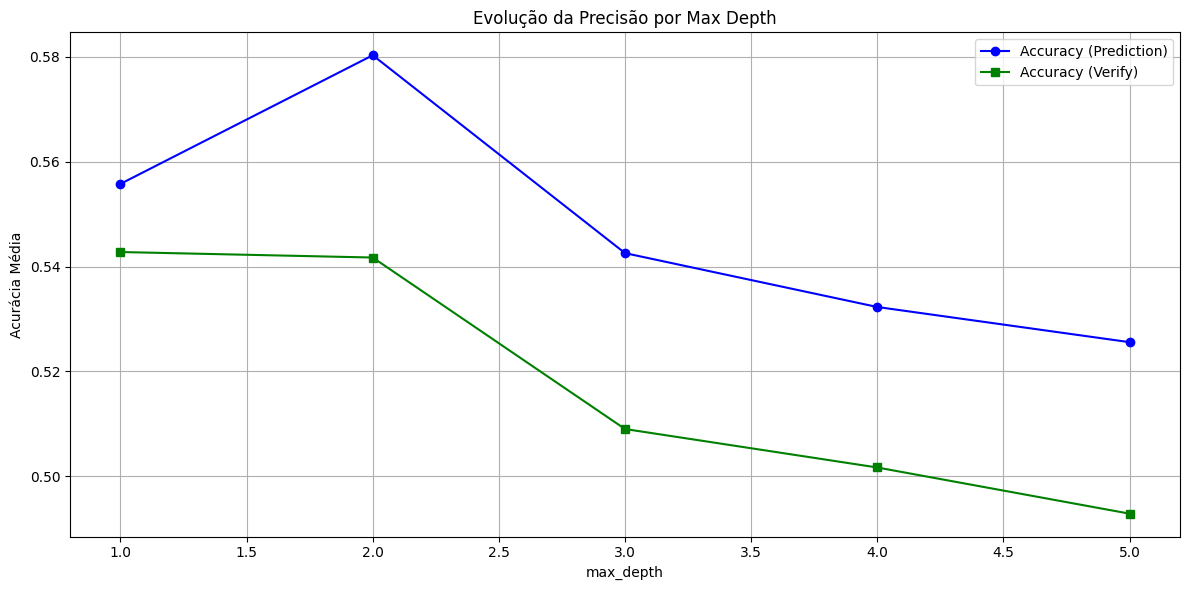

,max_depth,mean_accuracy_prediction,mean_accuracy_verify
0,1,0.555765,0.542767
1,2,0.580294,0.541719
2,3,0.542558,0.509015
3,4,0.532285,0.501677
4,5,0.525577,0.492872


In [99]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt
import warnings

# Desativa warnings
warnings.filterwarnings("ignore")

# Preparando as colunas de treino
X_Cols = price_data_ABEV[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']

# Variável adicional de verificação
verify = price_data_ABEV['Verify']

# Time Series Split: Número de divisões
tscv = TimeSeriesSplit(n_splits=5)

# Inicializando variáveis para armazenar resultados
accuracy_ytest_by_depth = []
accuracy_verify_by_depth = []
depth_values = []

# Laço para ajustar o max_depth de 1 a 40
for max_depth in range(1, 6):  # max_depth variando de 1 a 40
    print(f"\nAjustando o max_depth = {max_depth}:")
    
    # Criando o modelo Random Forest com o max_depth atual
    rand_frst_clf_Ambev = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", 
                                                 max_depth=max_depth, random_state=0)
    
    fold = 1  # Inicializando o contador do fold
    accuracy_scores_ytest = []
    accuracy_scores_verify = []

    for train_index, test_index in tscv.split(X_Cols):
        print(f"  Fold {fold}:")
        
        # Dividindo os dados em treino e teste para a divisão atual
        X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
        y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
        y_verify = verify.iloc[test_index]
        
        # Treinando o modelo
        rand_frst_clf_Ambev.fit(X_train, y_train)
        
        # Fazendo predições
        y_pred = rand_frst_clf_Ambev.predict(X_test)
        
        # Calculando acurácias
        accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
        accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
        accuracy_scores_ytest.append(accuracy_ytest)
        accuracy_scores_verify.append(accuracy_verify)

        # Exibindo acurácias para o fold atual
        print(f"    Accuracy with Y_test (Prediction): {accuracy_ytest:.2f}")
        print(f"    Accuracy with Verify: {accuracy_verify:.2f}")        

        fold += 1

    # Calculando as médias de acurácia para o max_depth atual
    mean_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
    mean_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

    # Armazenando as médias no gráfico
    depth_values.append(max_depth)
    accuracy_ytest_by_depth.append(mean_accuracy_ytest)
    accuracy_verify_by_depth.append(mean_accuracy_verify)

    # Exibindo os resultados do max_depth atual
    print(f"  Média da acurácia com Y_test (Prediction): {mean_accuracy_ytest:.2f}")
    print(f"  Média da acurácia com Verify: {mean_accuracy_verify:.2f}")

# Gerando gráficos para visualizar as métricas
plt.figure(figsize=(12, 6))

# Plotando as médias de acurácia
plt.plot(depth_values, accuracy_ytest_by_depth, label="Accuracy (Prediction)", marker="o", color="blue")
plt.plot(depth_values, accuracy_verify_by_depth, label="Accuracy (Verify)", marker="s", color="green")

# Configuração do gráfico
plt.title("Evolução da Precisão por Max Depth")
plt.xlabel("max_depth")
plt.ylabel("Acurácia Média")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Exibindo resumo final
results_df = pd.DataFrame({
    "max_depth": depth_values,
    "mean_accuracy_prediction": accuracy_ytest_by_depth,
    "mean_accuracy_verify": accuracy_verify_by_depth
})

results_df.head()



In [93]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd

# Supondo que você já tem o price_data_ABEV carregado
X_Cols = price_data_ABEV[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Lista para armazenar os resultados
results = []

# Lista de valores para max_depth (10, 20, ..., 1000 e None)
max_depth_values = list(range(10, 51, 10)) + [None]

# Loop para testar diferentes valores de max_depth
for max_depth in max_depth_values:
    # Criar o modelo de Random Forest com o max_depth atual
    rand_frst_clf = RandomForestClassifier(
        n_estimators=100,  # Número fixo de estimadores
        max_depth=max_depth,
        oob_score=True,
        criterion="gini",
        random_state=0
    )
    
    # Ajustar o modelo aos dados de treino
    rand_frst_clf.fit(X_train, y_train)
    
    # Fazer previsões nos dados de teste
    y_pred = rand_frst_clf.predict(X_test)
    
    # Calcular acurácia
    accuracy = accuracy_score(y_test, y_pred) * 100.0
    
    # Armazenar o resultado
    results.append((max_depth, accuracy))
    
    # Imprimir progresso
    max_depth_str = 'None' if max_depth is None else max_depth
    print(f'max_depth: {max_depth_str}, Accuracy: {accuracy:.2f}%')

# Converter resultados para um DataFrame para análise futura
results_df = pd.DataFrame(results, columns=['max_depth', 'Accuracy'])

# Exibir os 5 primeiros resultados
print(results_df.head())


max_depth: 10, Accuracy: 72.26%
max_depth: 20, Accuracy: 75.61%
max_depth: 30, Accuracy: 75.68%
max_depth: 40, Accuracy: 75.89%
max_depth: 50, Accuracy: 75.89%
max_depth: None, Accuracy: 75.89%
   max_depth   Accuracy
0       10.0  72.257163
1       20.0  75.611461
2       30.0  75.681342
3       40.0  75.890985
4       50.0  75.890985


#### Max_samples

In [101]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd

# Supondo que você já tem o price_data_ABEV carregado
X_Cols = price_data_ABEV[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Lista para armazenar os resultados
results = []

# Lista de valores para max_samples (10, 20, ..., 1000 e None)
max_samples_values = list(range(10, 51, 10)) + [None]

# Loop para testar diferentes valores de max_samples
for max_samples in max_samples_values:
    # Criar o modelo de Random Forest com o max_samples atual
    rand_frst_clf = RandomForestClassifier(
        n_estimators=100,  # Número fixo de estimadores
        max_samples=max_samples,
        oob_score=True,
        criterion="gini",
        random_state=0
    )
    
    # Ajustar o modelo aos dados de treino
    rand_frst_clf.fit(X_train, y_train)
    
    # Fazer previsões nos dados de teste
    y_pred = rand_frst_clf.predict(X_test)
    
    # Calcular acurácia
    accuracy = accuracy_score(y_test, y_pred) * 100.0
    
    # Armazenar o resultado
    results.append((max_samples, accuracy))
    
    # Imprimir progresso
    max_sambples_str = 'None' if max_samples is None else max_samples
    print(f'max_samples: {max_sambples_str}, Accuracy: {accuracy:.2f}%')




max_samples: 10, Accuracy: 61.64%
max_samples: 20, Accuracy: 63.59%
max_samples: 30, Accuracy: 63.73%
max_samples: 40, Accuracy: 62.82%
max_samples: 50, Accuracy: 64.29%
max_samples: None, Accuracy: 75.89%


#### Max_leafs

In [102]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd


# Supondo que você já tem o price_data_ABEV carregado
X_Cols = price_data_ABEV[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Lista para armazenar os resultados
results = []

# Lista de valores para max_leaf_nodes (10, 20, ..., 1000 e None)
max_leaf_nodes_values = list(range(10, 101, 10)) + [None]

# Loop para testar diferentes valores de max_leaf_nodes
for max_leaf_nodes in max_leaf_nodes_values:
    # Criar o modelo de Random Forest com o max_leaf_nodes atual
    rand_frst_clf = RandomForestClassifier(
        n_estimators=100,  # Número fixo de estimadores
        max_leaf_nodes=max_leaf_nodes,
        oob_score=True,
        criterion="gini",
        random_state=0
    )
    
    # Ajustar o modelo aos dados de treino
    rand_frst_clf.fit(X_train, y_train)
    
    # Fazer previsões nos dados de teste
    y_pred = rand_frst_clf.predict(X_test)
    
    # Calcular a acurácia
    accuracy = accuracy_score(y_test, y_pred) * 100.0
    
    # Armazenar o resultado
    results.append((max_leaf_nodes, accuracy))
    
    # Imprimir progresso
    max_leaf_nodes_str = 'None' if max_leaf_nodes is None else max_leaf_nodes
    print(f'max_leaf_nodes: {max_leaf_nodes_str}, Accuracy: {accuracy:.2f}%')



max_leaf_nodes: 10, Accuracy: 64.78%
max_leaf_nodes: 20, Accuracy: 65.20%
max_leaf_nodes: 30, Accuracy: 67.23%
max_leaf_nodes: 40, Accuracy: 68.13%
max_leaf_nodes: 50, Accuracy: 68.41%
max_leaf_nodes: 60, Accuracy: 69.25%
max_leaf_nodes: 70, Accuracy: 69.74%
max_leaf_nodes: 80, Accuracy: 69.95%
max_leaf_nodes: 90, Accuracy: 70.37%
max_leaf_nodes: 100, Accuracy: 70.79%
max_leaf_nodes: None, Accuracy: 75.89%


### ITAÚ